## **1 . Importación de librerias**

In [230]:
#Importación de librerias
import pandas as pd
import pvlib
from pvlib.pvsystem import retrieve_sam


- **pandas**: para manejar datos tabulares.
- **pvlib**: libreria especial para modelar el rendimiento de sistemas fotovoltaicos.
- **retrieve_sam**: se usa para obtener parámetros de paneles solares desde la base de datos del **NREL System Advisor Model** (SAM)

## **2. Carga y organización de datos**

In [231]:
import pandas as pd

df = pd.read_csv("datos/977348_9.93_-84.06_2023.csv", skiprows=2) 

df = df.rename(columns={
    'Year': 'Año', 'Month': 'Mes', 'Day': 'Día', 'Hour': 'Hora', 'Minute': 'Minuto',
    'GHI': 'GHI (W/m²)', 'DNI': 'DNI (W/m²)', 'DHI': 'DHI (W/m²)',
    'Wind Speed': 'Velocidad Viento (m/s)', 'Temperature': 'Temperatura (°C)',
    'Pressure': 'Presión (hPa)', 'Relative Humidity': 'Humedad Relativa (%)',
    "Solar Zenith Angle": "Ángulo Cenital Solar (°)"
})


df['datetime_naive'] = pd.to_datetime({
    'year': df['Año'],
    'month': df['Mes'],
    'day': df['Día'],
    'hour': df['Hora'],
    'minute': df['Minuto']
})

try:
    df_utc = df.set_index('datetime_naive').tz_localize('UTC', ambiguous='infer')
    print("Índice creado y localizado a UTC.")
    print(f"Zona horaria intermedia: {df_utc.index.tz}")

    df = df_utc.tz_convert('America/Costa_Rica')
    print("Índice convertido a America/Costa_Rica.")
    print(f"Zona horaria final del índice: {df.index.tz}")

except Exception as e:
    print(f"Error al localizar/convertir el índice: {e}")

df = df.drop(columns=['Año', 'Mes', 'Día', 'Hora', 'Minuto'])

df

Índice creado y localizado a UTC.
Zona horaria intermedia: UTC
Índice convertido a America/Costa_Rica.
Zona horaria final del índice: America/Costa_Rica


,GHI (W/m²),DHI (W/m²),DNI (W/m²),Temperatura (°C),Velocidad Viento (m/s),Humedad Relativa (%),Ángulo Cenital Solar (°),Presión (hPa)
datetime_naive,,,,,,,,
2022-12-31 18:30:00-06:00,0,0,0,20.5,0.4,99.98,105.41,907
2022-12-31 19:30:00-06:00,0,0,0,20.1,0.3,100.00,119.20,907
2022-12-31 20:30:00-06:00,0,0,0,19.8,0.3,100.00,132.95,908
2022-12-31 21:30:00-06:00,0,0,0,19.4,0.3,100.00,146.41,908
2022-12-31 22:30:00-06:00,0,0,0,19.1,0.3,100.00,158.84,907
...,...,...,...,...,...,...,...,...
2023-12-31 13:30:00-06:00,543,274,366,24.8,0.4,75.27,42.70,907
2023-12-31 14:30:00-06:00,509,186,540,24.3,0.4,78.15,53.21,907
2023-12-31 15:30:00-06:00,306,99,495,23.5,0.4,81.97,65.33,907


- Uso datos del NSRDB (una base satelital del NREL) para una ubicación específica en 2023.

- Los datos incluyen irradiancia (GHI, DNI, DHI), temperatura, humedad, velocidad del viento, presión y ángulo cenital solar.

- Después se renombra columnas y se crea una columna de tiempo (datetime) para indexar las variables por hora.

## **3. Selección del módulo solar**

In [232]:

cec_modules = retrieve_sam('CECMod')
module = cec_modules['Canadian_Solar_Inc__CS1U_430MS']
print(module)



Technology            Mono-c-Si
Bifacial                      0
STC                     430.803
PTC                       402.1
A_c                        1.99
Length                      NaN
Width                       NaN
N_s                          81
I_sc_ref                    9.9
V_oc_ref                   54.0
I_mp_ref                   9.51
V_mp_ref                   45.3
alpha_sc               0.006197
beta_oc               -0.148716
T_NOCT                     45.1
a_ref                  2.043637
I_L_ref               10.001098
I_o_ref                     0.0
R_s                    0.249883
R_sh_ref            1190.940552
Adjust                 8.405635
gamma_r                 -0.3448
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS1U_430MS, dtype: object


- retrieve_sam('CECMod') descarga los parámetros de paneles de la base de datos del CEC (California Energy Commission).

- Se selecciona un módulo específico: "Canadian_Solar_Inc__CS1U_430MS".

Este paso es clave porque estos parámetros (como Isc, Voc, Rs, Rsh, etc.) son los que se usan en el modelo físico Single Diode

### 📘 ¿Qué es el modelo Single Diode?

Es un modelo físico que representa a una celda solar con:
- Una fuente de corriente (fotogenerada),
- Un diodo (efecto de la unión pn),
- Una resistencia serie $ R_s $,
- Una resistencia en paralelo $ R_{sh} $.

**Ecuación general:**
$$
I = I_{L} - I_{0} \left( e^{\frac{V + IR_s}{n V_T}} - 1 \right) - \frac{V + IR_s}{R_{sh}}
$$

Donde:
- $ I_L $: corriente fotogenerada (proporcional a irradiancia),
- $ I_0 $: corriente de saturación inversa (dependiente de temperatura),
- $ n $: factor de idealidad,
- $ V_T $: voltaje térmico ($ \approx kT/q $).



## **4. Parámetros de ubicación y orientación del sistema, y obtención del ángulo solar azimutal**

In [233]:

surface_tilt =10  # Inclinación del panel
surface_azimuth = 288  #Hacia donde apunta el panel (grados)


lat, lon = 9.93673,-84.04388   # Coordenadas de la ubicación

location = pvlib.location.Location(latitude=lat, longitude=lon)
solar_position = location.get_solarposition(df.index) #posición solar para cada hora

solar_zenith = df["Ángulo Cenital Solar (°)"]  #
df["Angulo Azimuth Solar (°)"] = solar_position["zenith"]  


Primero define cómo están orientados los paneles respecto al plano horizontal (tilt) y hacia dónde están apuntando (azimuth).

Luego crea un objeto Location que representa tu sitio geográfico y calcula la posición solar (zenith, azimuth, etc.) para cada hora del dataset.

- La posición solar es fundamental para proyectar la radiación en el plano inclinado del panel. Sin ella, no se podria calcular cuánta irradiancia real llega al panel.

Posterior a ello, se agrega el  ángulo azimuth solar, necesario para calcular la irradiancia en el plano del panel.


## **5. Cálculo de POA (Plane of Array Irradiance)**

In [234]:
poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    dni=df['DNI (W/m²)'],
    ghi=df['GHI (W/m²)'],
    dhi=df['DHI (W/m²)'],
    solar_zenith=df['Ángulo Cenital Solar (°)'],
    solar_azimuth=df['Angulo Azimuth Solar (°)']
    
)

df["POA"] = poa["poa_global"]  # Agregar la columna de irradiancia en el plano del panel al DataFrame




**get_total_irradiance()** calcula cuánta irradiancia (en W/m²) llega al plano del panel, considerando geometría y reflexión (albedo). Esto incluye:

- DNI proyectado (directa normal corregida por ángulo de incidencia)

- Difusa del cielo

- Reflejada del suelo

>El POA es la irradiancia real que recibe el módulo. Es un paso esencial para estimar la potencia generada por el panel, y sí, es ampliamente usado en simulación y diseño de sistemas reales.

## **6. Módelo de temperatura de celda**

In [235]:
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

print(TEMPERATURE_MODEL_PARAMETERS['sapm'].keys())



dict_keys(['open_rack_glass_glass', 'close_mount_glass_glass', 'open_rack_glass_polymer', 'insulated_back_glass_polymer'])


Este paso es para mostrar qué modelos de instalación hay disponibles ('open_rack_glass_glass', 'close_mount_glass_glass', 'open_rack_glass_polymer', 'insulated_back_glass_polymer')
.


In [236]:
from pvlib.temperature import sapm_cell, TEMPERATURE_MODEL_PARAMETERS


#Para un panel en un techo
temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['close_mount_glass_glass']
print("Parámetros para techo:", temp_params)
#Esto define parámetros para estimar la temperatura de celda con el modelo SAPM (Sandia Array Performance Model)

df['Temperatura de Celda'] = sapm_cell(
    poa_global=df['POA'],
    temp_air=df['Temperatura (°C)'],
    wind_speed=df['Velocidad Viento (m/s)'],
    **temp_params                          # a, b, deltaT
)


Parámetros para techo: {'a': -2.98, 'b': -0.0471, 'deltaT': 1}


> Este modelo estima la temperatura interna del módulo. Es importante porque la eficiencia cae conforme aumenta la temperatura.



## **7. Estimar parámetros eléctricos con calcparams_cec**

Este paso utiliza el modelo de un solo diodo, y la variante CEC (California Energy Commission), que ya incluye muchos parámetros definidos en la base de datos del módulo.

In [237]:
from pvlib.pvsystem import calcparams_cec, singlediode

alpha_sc = module['alpha_sc']
a_ref    = module['a_ref']
I_L_ref  = module['I_L_ref']
I_o_ref  = module['I_o_ref']
R_sh_ref = module['R_sh_ref']
R_s      = module['R_s']
Adjust   = module['Adjust']  # ajuste a alpha_sc en %

cec_params = calcparams_cec(
    effective_irradiance = df['POA'],   # W/m²
    temp_cell            = df['Temperatura de Celda'],    # °C
    alpha_sc             = alpha_sc,           # A/°C
    a_ref                = a_ref,              # V
    I_L_ref              = I_L_ref,            # A
    I_o_ref              = I_o_ref,            # A
    R_sh_ref             = R_sh_ref,           # Ω
    R_s                  = R_s,                # Ω
    Adjust               = Adjust              # %
)






### 🧠 ¿Qué hace `calcparams_cec()`?

Este método calcula los **cinco parámetros** del modelo de un solo diodo para cada hora del año, dados:

- **Irradiancia efectiva (POA)**
- **Temperatura de celda**

Y los parámetros del módulo, que vienen de la base CEC.



## **8. Obtener la potencia estimada con `singlediode()`**

In [238]:
#Desempaqueta los parámetros y calcula el punto de máxima potencia
IL, I0, Rs, Rsh, nNsVth = cec_params
sd = singlediode(IL, I0, Rs, Rsh, nNsVth)

# Guarda la potencia estimada
df['Potencia_estimada (W)'] = sd['p_mp']  # potencia máxima esperada en W

### 🔎 ¿Qué hace `singlediode()`?

A partir de los 5 parámetros anteriores, resuelve la ecuación no lineal **numéricamente** y calcula:

- `i_mp`: corriente en el punto de máxima potencia
- `v_mp`: voltaje en el punto de máxima potencia
- `p_mp`: potencia máxima = $ i_{mp} \times v_{mp} $
- `i_sc`, `v_oc`: corriente de cortocircuito y voltaje de circuito abierto

---

## **9. Graficación de comportamiento de variables climaticas durante el año y valores de tempertatura, y potencia**

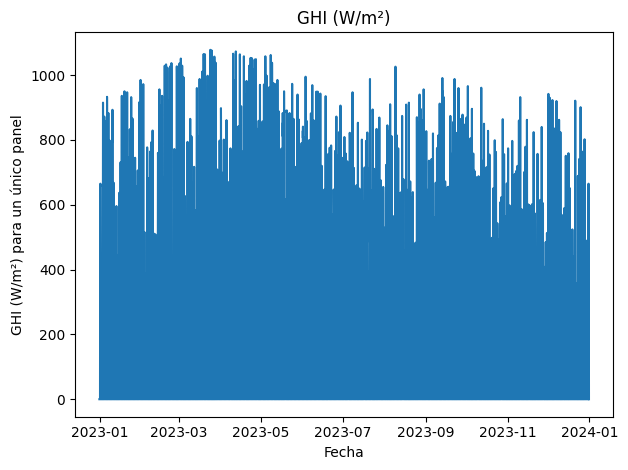

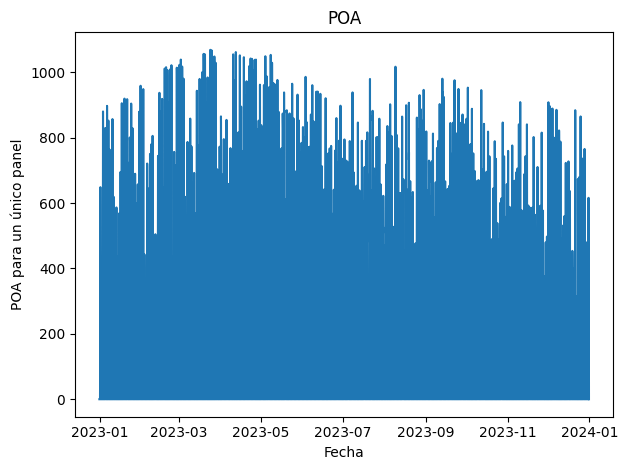

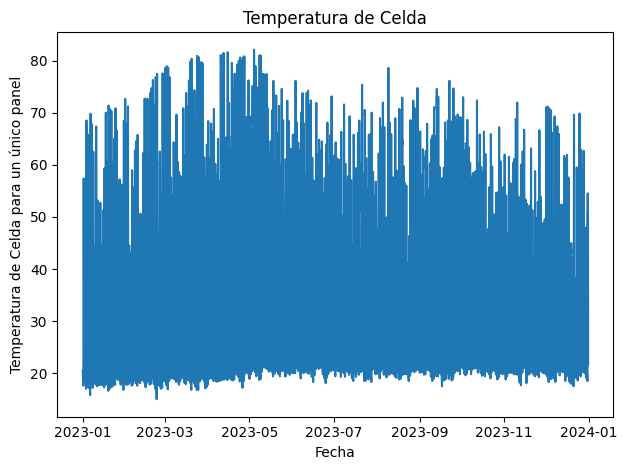

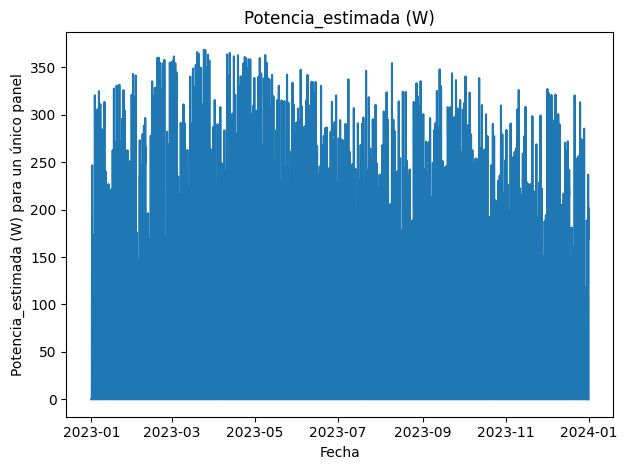

In [239]:
import matplotlib.pyplot as plt

# Lista de columnas a graficar
columnas = ['GHI (W/m²)', 
       'POA', 'Temperatura de Celda', 'Potencia_estimada (W)']

for col in columnas:
    plt.figure()                # 1 figura por variable
    plt.plot(df.index, df[col]) # serie de tiempo
    plt.title(col)              # título = nombre de la variable
    plt.xlabel('Fecha')
    plt.ylabel(f"{col} para un único panel")
    plt.tight_layout()          # ajustar márgenes
    plt.show()


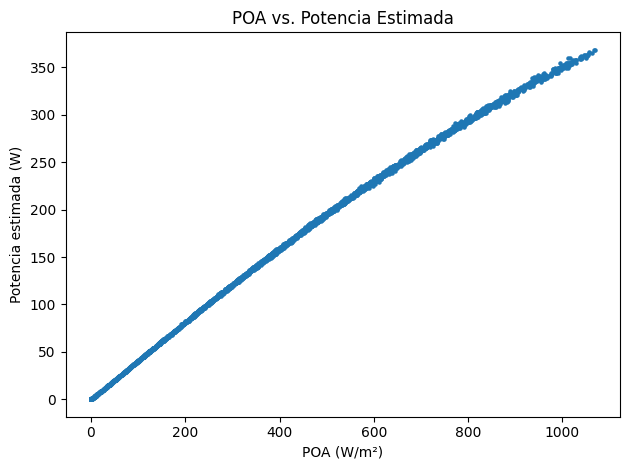

In [240]:
plt.figure()
plt.scatter(df['POA'], df["Potencia_estimada (W)"], s=5)
plt.title('POA vs. Potencia Estimada')
plt.xlabel('POA (W/m²)')
plt.ylabel('Potencia estimada (W)')
plt.tight_layout()
plt.show()


In [241]:
#Cálculo de energía anual estimada

Energía_anual_kWh = df['Potencia_estimada (W)'].sum() / 1000  # kWh
print(f"Energía anual estimada: {Energía_anual_kWh:.2f} kWh")

#Factor de Capacidad
potencia_stc_kW = module['STC'] / 1000
Factor_de_Capacidad = (Energía_anual_kWh / (potencia_stc_kW * 8760)) * 100
print(f"Factor de Capacidad: {Factor_de_Capacidad:.2f} %")



Energía anual estimada: 628.09 kWh
Factor de Capacidad: 16.64 %


In [242]:
import plotly.express as px
import pandas as pd
import calendar 

if isinstance(df.index, pd.DatetimeIndex):
    df['HoraDelDia'] = df.index.hour
    df['MesNum'] = df.index.month
    df['MesNombre'] = df['MesNum'].apply(lambda x: calendar.month_abbr[x])

 
    perfil_promedio = df.groupby(['MesNombre', 'MesNum', 'HoraDelDia'])['Potencia_estimada (W)'].mean().reset_index()
    perfil_promedio.sort_values(by=['MesNum', 'HoraDelDia'], inplace=True)

    fig_perfil_pot = px.line(
        perfil_promedio,
        x='HoraDelDia',
        y='Potencia_estimada (W)', 
        color='MesNombre',          
        title='Perfil Diario Promedio de Potencia Estimada por Mes',
        labels={ # Etiquetas más descriptivas
            'HoraDelDia': 'Hora del Día',
            'Potencia_estimada (W)': 'Potencia Promedio (W)', 
            'MesNombre': 'Mes'
        },
        markers=False 
    )

 

    fig_perfil_pot.update_xaxes(range=[0, 23], dtick=2) # Marcas cada 2 horas en eje X
    fig_perfil_pot.update_yaxes(title_text='Potencia Promedio Estimada (W)') # Título específico eje Y

    fig_perfil_pot.show()

else:
    print("Error: El índice del DataFrame no es de tipo DatetimeIndex.")